# Risk‑Aware Insurance Pricing

## Notebook 02 — Extension of the core model to estimate uncertainty and tail risk

## 1️ Why Quantile Regression?

Traditional regression models predict only the **expected (mean)** value of the insurance premium.  
In insurance pricing, this is often **not sufficient** because risk is inherently asymmetric.

### Why mean prediction is risky
- **Under-pricing high-risk customers** → direct financial losses  
- **Over-pricing low-risk customers** → poor customer retention  
- Business decisions require visibility into **best-case, typical, and worst-case** outcomes

### What Quantile Regression does differently
Quantile Regression models the **conditional distribution** of the target variable instead of a single average.

Instead of predicting:
# Premium ≈ ₹25,000


We estimate multiple risk-aware scenarios:
- **10th percentile** → Conservative lower bound (low risk)
- **50th percentile** → Median / typical estimate
- **90th percentile** → Risk-aware upper bound (high risk)

This makes quantile regression especially well-suited for **insurance pricing, risk modeling, and underwriting decisions**.

---

## 2️ Prerequisites

This notebook assumes the following steps have already been completed:

- Feature engineering with interaction terms  
  - `X_train_int`, `X_test_int`
- Target transformation  
  - `y_train`, `y_test` (log-transformed premium)

These inputs are generated in:

> **Notebook 01: Core Hybrid Model**

Please ensure Notebook 01 has been executed before proceeding.

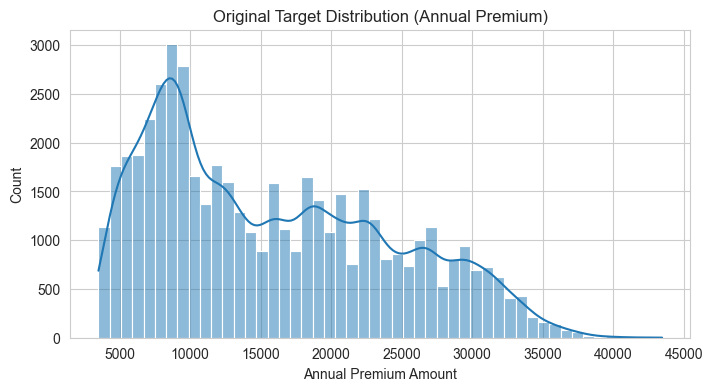

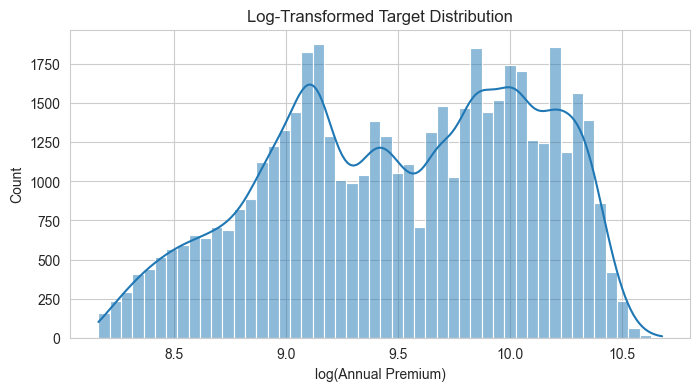

Linear Regression Results:
Train R²: 0.8886522171713429
Test R²: 0.8767849149208222
RMSE: 0.20357282763475934
Renamed 2 columns


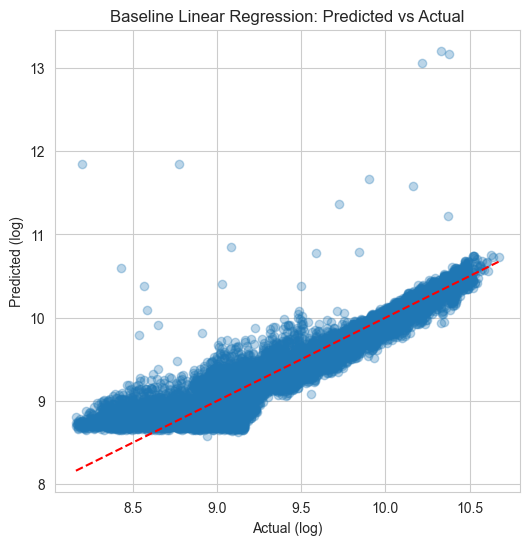

Extreme Error Rate (>10%): 0.14%


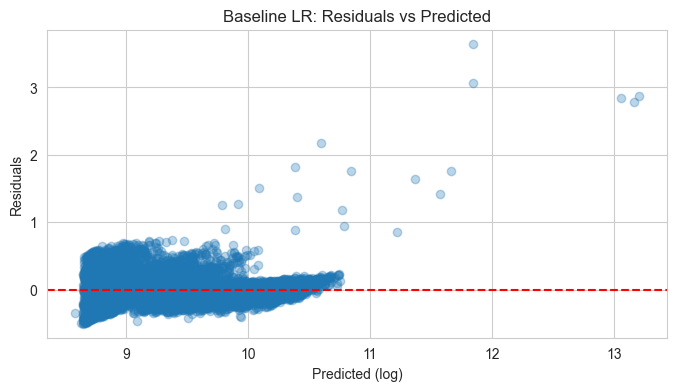

Linear Regression Results after One-Hot-Encoding
R²: 0.87712881936793
RMSE: 0.20328853403644104


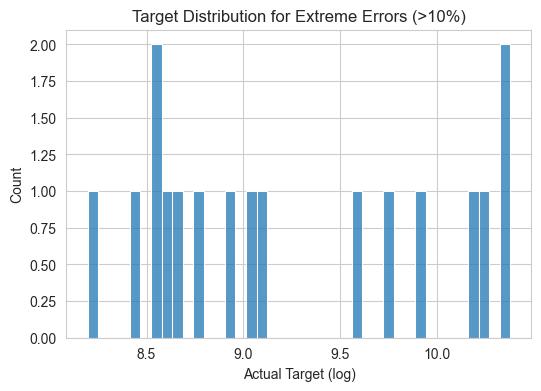

Final prediction = Linear Regression + Residual XGBoost
Final R²: 0.9262970126073523
Final RMSE: 0.15744555861720733
Extreme error rate (>10%): 0.008


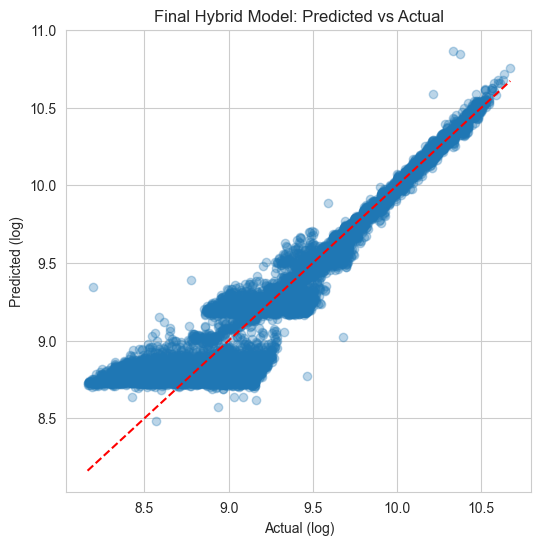

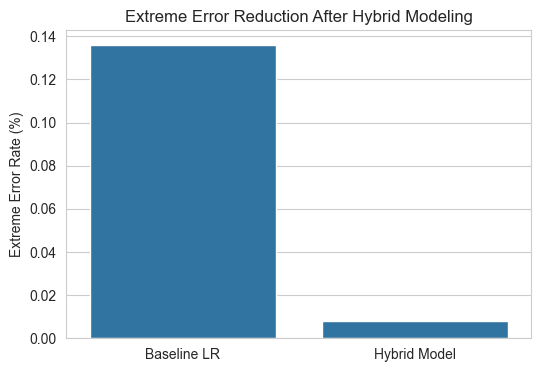

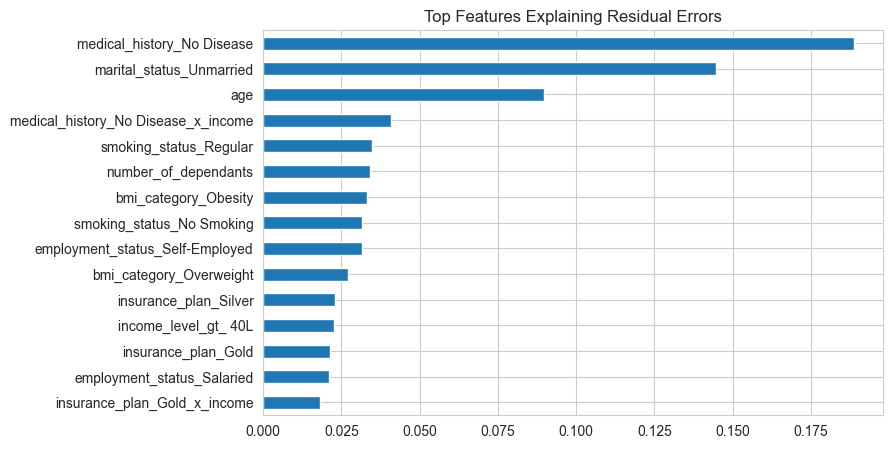

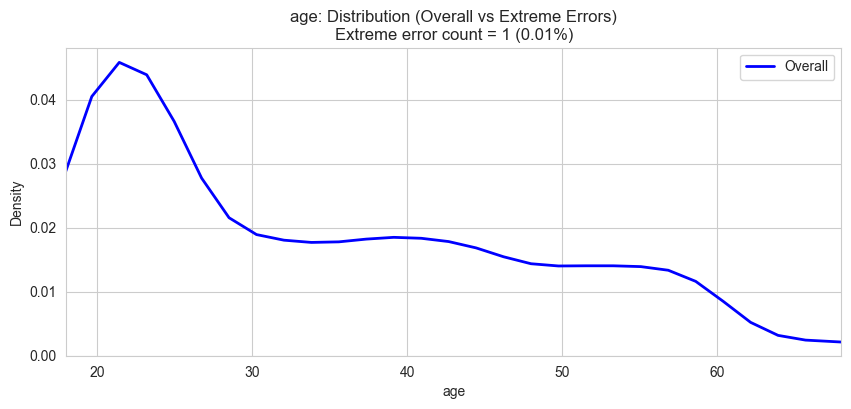

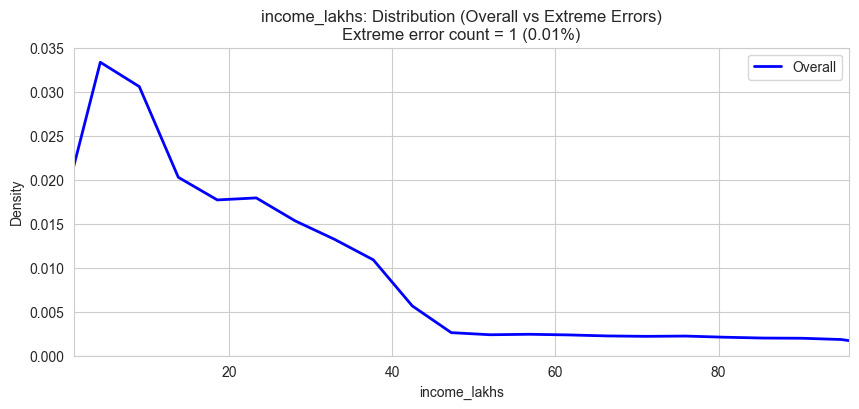

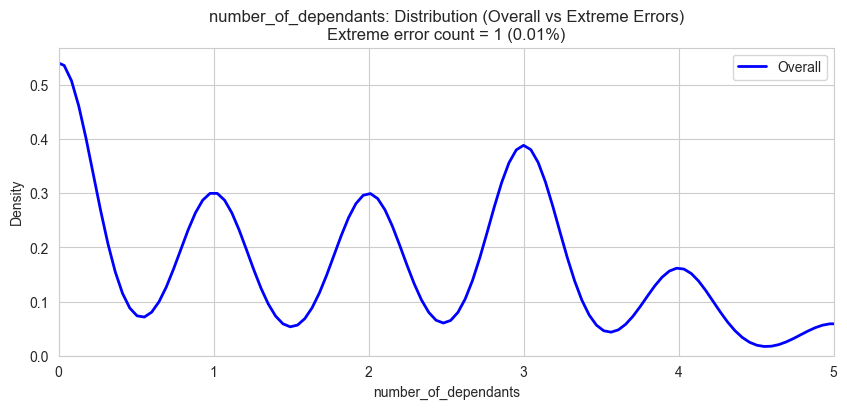

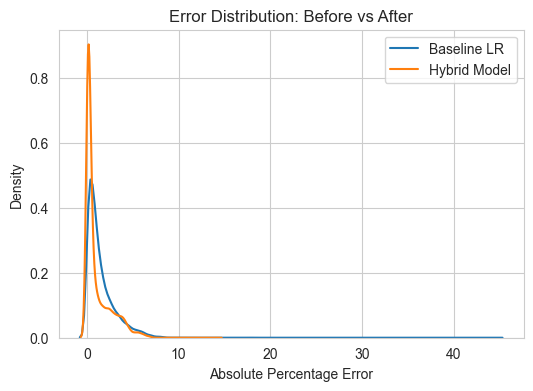

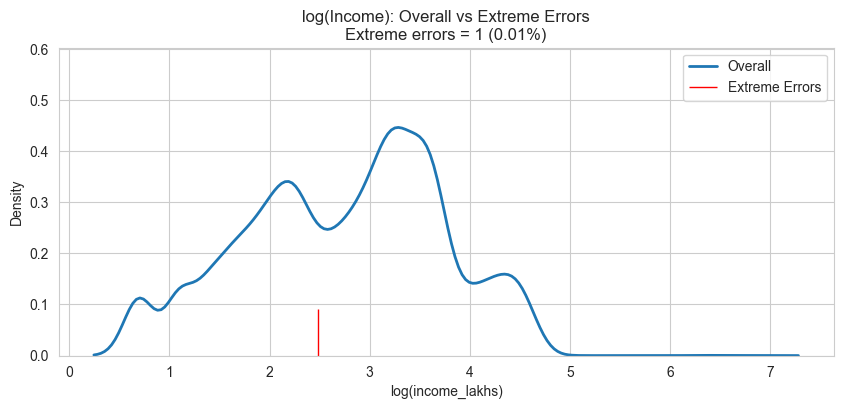

In [2]:
%run 01_Core_Hybrid_Model.ipynb

# Quantile XGBoost

In [3]:
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}

In [4]:
from xgboost import XGBRegressor

for q in quantiles:
    model = XGBRegressor(
        objective="reg:quantileerror",
        quantile_alpha=q,
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train_int, y_train)
    quantile_models[q] = model

In [5]:
pred_q10 = quantile_models[0.1].predict(X_test_int)
pred_q50 = quantile_models[0.5].predict(X_test_int)
pred_q90 = quantile_models[0.9].predict(X_test_int)

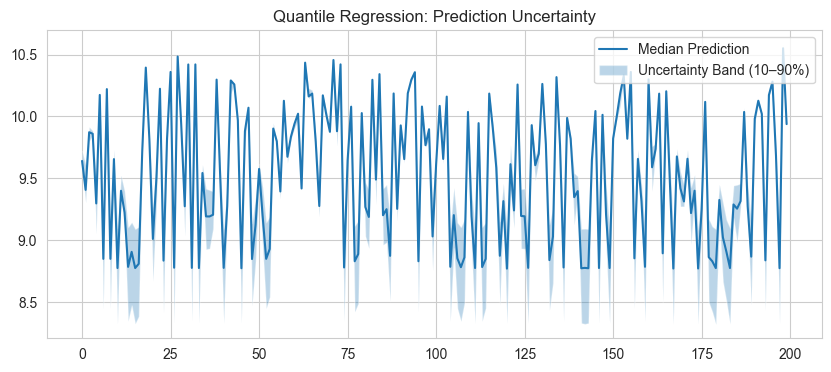

In [6]:
idx = np.random.choice(len(y_test), 200, replace=False)

plt.figure(figsize=(10,4))
plt.plot(pred_q50[idx], label='Median Prediction')
plt.fill_between(
    range(len(idx)),
    pred_q10[idx],
    pred_q90[idx],
    alpha=0.3,
    label='Uncertainty Band (10–90%)'
)
plt.legend()
plt.title("Quantile Regression: Prediction Uncertainty")
plt.show()

#### Interpretation
- Narrow bands → high confidence in pricing
- Wide bands → uncertain or high‑risk customers
#### I extended the regression model to quantile prediction to estimate uncertainty bounds, which is critical in insurance pricing to avoid underestimation risk.

### Practical Use in Insurance
#### Quantile outputs enable:
- Risk‑aware pricing: use upper quantile for high‑risk customers
- Customer segmentation based on uncertainty
- Stress testing premium strategies